In [11]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random

pd.set_option('display.max_rows', None)

# GB1 clustering 

In [131]:
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
aln = aln.drop_duplicates(subset=['sequence'])
#aln = aln.sample(frac=0.2)
aln.drop(columns=["encoding", "weights"], inplace=True)
print(aln.shape)
aln.head()

msa, seq_key, key_label = st.convert_msa_numpy_array(aln)
msa.shape

(14276, 2)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)


(14276, 448)

In [132]:
aln.head()

,id,sequence
0,N0_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
1,N1_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
3,N3_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
6,N6_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
7,N7_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTTVAADSAIEDTPIIRN...


In [ ]:
st.write_fasta_file("gb1_ancestors_extants_no_dupes.fasta", aln)

In [13]:
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/gb1_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape


(55,)

In [15]:
results.loc[results["is_ancestor"] == 0].shape

(1543, 3)

In [125]:
SAMPLE_SIZE = 100
extant_proportions = [0.15, 0.10, 0.05, 0.0]


random.seed(42)

for p in extant_proportions:
    
    all_indices = []
    reps = []

    for r in range(1, 5):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        all_indices.append(indices)
        reps.append(r)

    test = pd.DataFrame({"replicate": reps, "indices": all_indices})
    test.to_csv(f"gb1_{p}_replicates.csv", index=False)

#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

In [135]:
test = pd.read_csv("gb1_0.0_replicates.csv", )

indices = test.loc[
    test["replicate"] == 3, "indices"
].values[0]

indices = [int(x.strip()) for x in indices[1:-1].split(",")]
print(indices[:10])

thing = aln.loc[indices]


[138, 139, 369, 854, 1037, 1357, 1360, 1558, 2418, 2714]


In [144]:
numpy_aln, _, _ = st.convert_msa_numpy_array(thing)
weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
one_hot = thing["sequence"].apply(st.seq_to_one_hot)
thing["weights"] = weights
thing["encoding"] = one_hot

Sequence weight numpy array created with shape (num_seqs, columns):  (100, 448)


In [145]:
thing.head()

,id,sequence,encoding,weights
138,N138_gb1_tree_1,-KNNTNRHYSLRKLKTGTASVAVALTLGTGLVAGQTVKADARSVNG...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.5
139,N139_gb1_tree_1,-KNNTNRHYSLRKLKTGTASVAVALTLGTGLVAGQTVKADARSVNG...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.5
369,N369_gb1_tree_1,----TNKQYSLRKLKTGTASVAVAVALGAGFANQTEVKADSPKSSN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.5
854,N854_gb1_tree_1,----------------------------------------------...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0
1037,N1037_gb1_tree_1,----------------------------------------------...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0


In [33]:
for p in extant_proportions:
    for r in range(1, 2):
        samp_aln = aln.loc[indices]
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        print(samp_aln.head())
        #samp_aln.to_pickle(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")


Sequence weight numpy array created with shape (num_seqs, columns):  (10000, 448)
              id                                           sequence   weights
0  N0_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
1  N1_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
6  N6_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
7  N7_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTTVAADSAIEDTPIIRN...  0.032258
9  N9_gb1_tree_1  MEKNKKVSYFLRQSAVGLASVSAAFLVGTTSVGALDAEPTTAFIRE...  0.028571
Sequence weight numpy array created with shape (num_seqs, columns):  (10000, 448)
              id                                           sequence   weights
0  N0_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
1  N1_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
6  N6_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...  0.033333
7  N7_gb1_tree_1  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTTVAADSAI

In [ ]:
test = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/replicate_encoded_weighted/gb1_ancestors_extants_no_dupes_clustered_r1_extant_0.12_encoded_weighted.pkl")
test.loc[~test["id"].str.contains("tree")]

#### Results

In [24]:
import os

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gb1/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if file != ".DS_Store"]


In [35]:

all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
#all_data = pd.concat(df_list, ignore_index=True)
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[3] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]

In [36]:
all_data

,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,replicate,extant_prop,covariance
0,./rep_1_train_02_encoded_weighted_dms_SPG1_STR...,0.150893,0.269349,0.125566,0.696780,1,02,0.917
1,./rep_1_train_22_encoded_weighted_dms_SPG1_STR...,0.100515,0.217863,0.092049,0.648401,1,22,0.766
2,./rep_1_train_17_encoded_weighted_dms_SPG1_STR...,0.070434,0.183583,0.147817,0.616572,1,17,0.823
3,./rep_1_train_0_encoded_weighted_dms_SPG1_STRS...,0.221269,0.308516,0.121945,0.749716,1,0,0.918
4,./rep_1_train_07_encoded_weighted_dms_SPG1_STR...,0.151526,0.255423,0.127605,0.714219,1,07,0.906
5,./rep_1_train_12_encoded_weighted_dms_SPG1_STR...,0.285379,0.314810,0.093017,0.789568,1,12,0.896
6,./rep_2_train_17_encoded_weighted_dms_SPG1_STR...,0.096651,0.202531,0.036611,0.636637,2,17,0.786
7,./rep_2_train_22_encoded_weighted_dms_SPG1_STR...,0.079701,0.197242,0.129404,0.633429,2,22,0.833
8,./rep_2_train_02_encoded_weighted_dms_SPG1_STR...,0.101951,0.214850,0.081736,0.662705,2,02,0.875
9,./rep_2_train_12_encoded_weighted_dms_SPG1_STR...,0.180741,0.269885,0.055540,0.739429,2,12,0.916


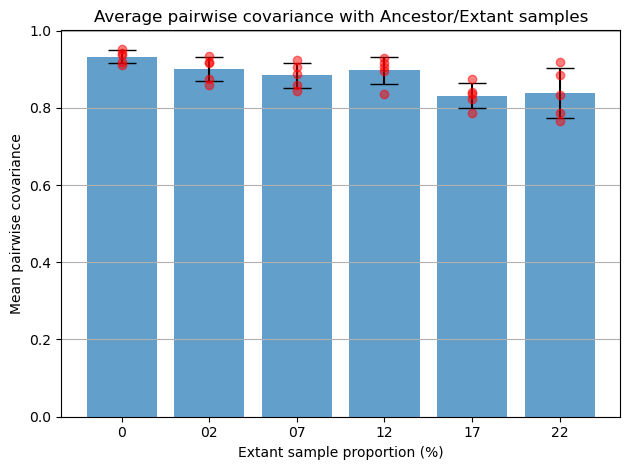

In [37]:
import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions

means = [point["covariance"].mean() for point in points]
std_devs = [point["covariance"].std() for point in points] 

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

# Create bars
bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

for i, point in enumerate(points):
    ax.scatter([i]*len(point), point["covariance"], color='red', zorder=3, alpha=0.5)


# Add labels
ax.set_xlabel('Extant sample proportion (%)')
ax.set_ylabel('Mean pairwise covariance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

#ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
ax.set_title('Average pairwise covariance with Ancestor/Extant samples')


# Add a grid for better readability
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
plt.show()

# A4 human clustering 

In [25]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/mmseqs_clustering/a4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results


,cluster,sequence,is_ancestor
0,N1147_a4_tree_0,N1147_a4_tree_0,1
1,N1147_a4_tree_0,N1140_a4_tree_0,1
2,N1147_a4_tree_0,N1358_a4_tree_1,1
3,N1147_a4_tree_0,N1362_a4_tree_1,1
4,N1147_a4_tree_0,N1387_a4_tree_4,1
...,...,...,...
32120,N3313_a4_tree_0,N3907_a4_tree_30,1
32121,N3313_a4_tree_0,UniRef100_UPI001F080ADC/14-747,0
32122,N3313_a4_tree_0,UniRef100_A0A8C9ZFS8/9-558,0
32123,N3313_a4_tree_0,UniRef100_A0A8C9ZCJ7/7-555,0


In [17]:
aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta")

encodings, weights = st.encode_and_weight_seqs(aln, 0.2)

aln["encoding"] = encodings
aln["weights"] = weights
aln
aln 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 348
Encoding the sequences and calculating weights
The sequence encoding has size: (348,)

Sequence weight numpy array created with shape (num_seqs, columns):  (348, 281)
The sequence weight array has size: (348,)



,id,sequence,encoding,weights
0,GCN4_YEAST/1-281,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0625
1,UniRef100_A0A6V8SDC1/2-278,-SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0625
2,UniRef100_P03069/2-278,-SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0625
3,UniRef100_A0A6V8RYM2/2-278,-SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0625
4,UniRef100_A0A7I9BU78/2-278,-SEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPVVGQLIFD...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0625
...,...,...,...,...
343,UniRef100_A0A2H3I9P9/247-531,----------------------TPNYQKNQHKQHQTHPQQHRRVMS...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.5000
344,UniRef100_A0A0D2JFS6/140-356,---------------------------------------SHDDFMD...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0000
345,UniRef100_W9XLE4/26-239,----------------------------------------------...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0000
346,UniRef100_A0A0D2EC58/22-237,-------------------------------------------FFN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0000


In [18]:
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants_encoded_weighted.pkl")

In [6]:
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_encoded_weighted.pkl")

In [41]:
clustering_results[clustering_results["is_ancestor"] == 0]

,cluster,sequence,is_ancestor
29,N1147_a4_tree_0,UniRef100_A0A7N8YDR4/6-565,0
30,N1147_a4_tree_0,UniRef100_A0A7N6BYD0/5-552,0
31,N1147_a4_tree_0,UniRef100_A0A3Q1JL59/5-546,0
32,N1147_a4_tree_0,UniRef100_A0A7N9ATZ4/6-548,0
1179,N1681_a4_tree_0,UniRef100_UPI000E1D8C12/26-745,0
...,...,...,...
32081,N3312_a4_tree_0,UniRef100_A0A672J9D9/8-550,0
32121,N3313_a4_tree_0,UniRef100_UPI001F080ADC/14-747,0
32122,N3313_a4_tree_0,UniRef100_A0A8C9ZFS8/9-558,0
32123,N3313_a4_tree_0,UniRef100_A0A8C9ZCJ7/7-555,0


In [37]:
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

83

In [42]:
SAMPLE_SIZE = 10000
extant_proportions = [0.2185, 0.15, 0.1, 0.05, 0.0]


aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_ancestors_extants_no_dupes.fasta", encode=False)

random.seed(42)

for p in extant_proportions:
    for r in range(1, 6):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        st.write_fasta_file(f"./a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_ancestors_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 32125


In [43]:
for p in extant_proportions:
    for r in range(1, 6):
        samp_aln = st.read_aln_file(f"./a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta")
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        samp_aln.to_pickle(f"a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")

Reading the alignment: ./a4_ancestors_extants_no_dupes_clustered_r1_extant_0.2185.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 10000
Sequence weight numpy array created with shape (num_seqs, columns):  (10000, 770)
Reading the alignment: ./a4_ancestors_extants_no_dupes_clustered_r2_extant_0.2185.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 10000
Sequence weight numpy array created with shape (num_seqs, columns):  (10000, 770)
Reading the alignment: ./a4_ancestors_extants_no_dupes_clustered_r3_extant_0.2185.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 10000
Sequence weight numpy array created with shape (num_seqs, columns):  (10000, 770)
Reading the alignment: ./a4_ancestors_extants_no_dupes_clustered_r4_extant_0.2185.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Numb

In [63]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/a4/"

df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.concat(df_list, ignore_index=True)

#all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)


get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]


In [64]:
all_data

,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,replicate,extant_prop
0,./rep_1_train_a4_ancestors_extants_no_dupes_cl...,0.053720,0.114035,0.647926,0.534209,1,00
1,./rep_5_train_a4_ancestors_extants_no_dupes_cl...,0.200275,0.121457,0.645440,0.608489,5,015
2,./rep_3_train_a4_ancestors_extants_no_dupes_cl...,0.111668,0.119433,0.626572,0.563855,3,00
3,./rep_3_train_a4_ancestors_extants_no_dupes_cl...,-0.005630,0.111336,0.627702,0.504191,3,02185
4,./rep_4_train_a4_ancestors_extants_no_dupes_cl...,0.127819,0.126856,0.599714,0.572651,4,01
5,./rep_2_train_a4_ancestors_extants_no_dupes_cl...,0.205060,0.121457,0.625174,0.610251,2,015
6,./rep_5_train_a4_ancestors_extants_no_dupes_cl...,0.145975,0.127530,0.609509,0.580131,5,01
7,./rep_1_train_a4_ancestors_extants_no_dupes_cl...,0.138021,0.125506,0.655639,0.577158,1,005
8,./rep_2_train_a4_ancestors_extants_no_dupes_cl...,0.086917,0.148448,0.596941,0.540862,2,00
9,./rep_2_train_a4_ancestors_extants_no_dupes_cl...,0.067326,0.107962,0.523257,0.534644,2,02185


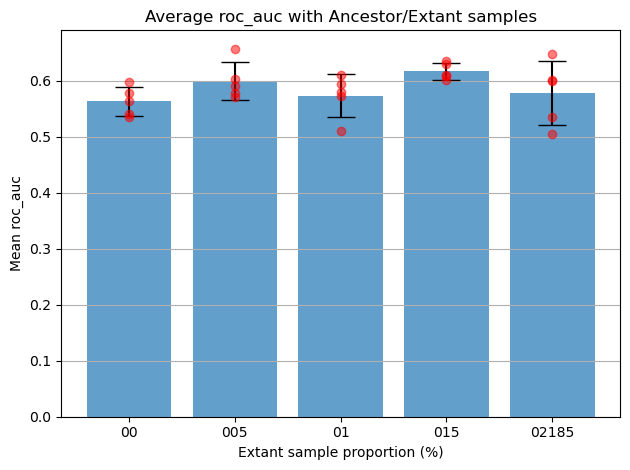

In [68]:
import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions

means = [point["roc_auc"].mean() for point in points]
std_devs = [point["roc_auc"].std() for point in points] 

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

# Create bars
bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

for i, point in enumerate(points):
    ax.scatter([i]*len(point), point["roc_auc"], color='red', zorder=3, alpha=0.5)


# Add labels
ax.set_xlabel('Extant sample proportion (%)')
ax.set_ylabel('Mean roc_auc')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

#ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
ax.set_title('Average roc_auc with Ancestor/Extant samples')


# Add a grid for better readability
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
plt.show()

# GCN4 clustering

In [57]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/mmseqs_clustering/gcn4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results


,cluster,sequence,is_ancestor
0,UniRef100_H2B208/41-248,UniRef100_H2B208/41-248,0
1,UniRef100_H2B208/41-248,UniRef100_J7RCV7/44-270,0
2,UniRef100_H2B208/41-248,N334_gcn4_tree_1,1
3,UniRef100_H2B208/41-248,N35_gcn4_tree_7,1
4,UniRef100_H2B208/41-248,N32_gcn4_tree_9,1
...,...,...,...
11899,N316_gcn4_tree_12,N296_gcn4_tree_12,1
11900,N315_gcn4_tree_11,N315_gcn4_tree_11,1
11901,N316_gcn4_tree_10,N316_gcn4_tree_10,1
11902,N315_gcn4_tree_86,N315_gcn4_tree_86,1


In [58]:
# divide the sequences into their clusters
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

76

In [55]:
# remove duplcates 

# aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants.fasta", encode=False)
# aln = aln.drop_duplicates(subset=["sequence"])
# aln
# st.write_fasta_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.fasta", aln)

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 348


In [63]:

SAMPLE_SIZE = 5000
extant_proportions = [0.0662, 0.05, 0.025, 0.01, 0.0]


aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.fasta", encode=False)

random.seed(42)

for p in extant_proportions:
    for r in range(1, 6):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        st.write_fasta_file(f"./gcn4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)



Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 11904


In [64]:
for p in extant_proportions:
    for r in range(1, 6):
        samp_aln = st.read_aln_file(f"./gcn4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta")
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        samp_aln.to_pickle(f"gcn4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")

Reading the alignment: ./gcn4_ancestors_extants_no_dupes_clustered_r1_extant_0.0662.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 5000
Sequence weight numpy array created with shape (num_seqs, columns):  (5000, 281)
Reading the alignment: ./gcn4_ancestors_extants_no_dupes_clustered_r2_extant_0.0662.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 5000
Sequence weight numpy array created with shape (num_seqs, columns):  (5000, 281)
Reading the alignment: ./gcn4_ancestors_extants_no_dupes_clustered_r3_extant_0.0662.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 5000
Sequence weight numpy array created with shape (num_seqs, columns):  (5000, 281)
Reading the alignment: ./gcn4_ancestors_extants_no_dupes_clustered_r4_extant_0.0662.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Nu

In [45]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gcn4/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]



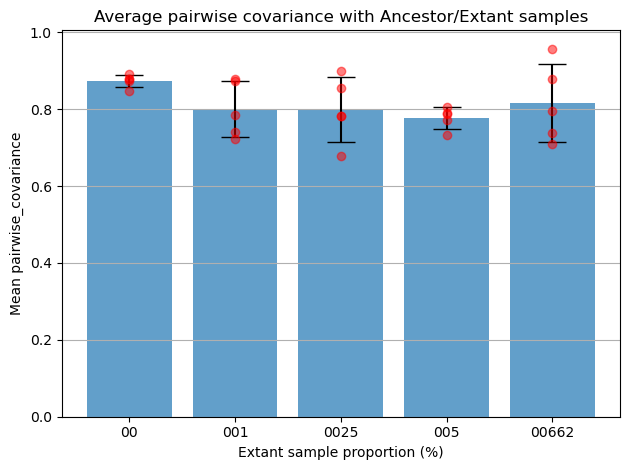

In [48]:
import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions

means = [point["covariance"].mean() for point in points]
std_devs = [point["covariance"].std() for point in points] 

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

# Create bars
bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

for i, point in enumerate(points):
    ax.scatter([i]*len(point), point["covariance"], color='red', zorder=3, alpha=0.5)


# Add labels
ax.set_xlabel('Extant sample proportion (%)')
ax.set_ylabel('Mean pairwise_covariance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

#ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
ax.set_title('Average pairwise covariance with Ancestor/Extant samples')


# Add a grid for better readability
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
plt.show()

# Alternate clustering: incomplete

In [ ]:

test = st.read_aln_file("../data/pair_test.aln")
test_msa, _, _ = st.convert_msa_numpy_array(test)

@njit(parallel=True)
def adj_matrix(msa) -> np.ndarray:

    sim_matrix = np.ones((msa.shape[0], msa.shape[0]))
    seq_len = len(msa[0])

    for i in prange(msa.shape[0]):
        for j in prange(i + 1, msa.shape[0]):
            dist = 1 - (mt.hamming_distance(msa[i], msa[j]) / seq_len)
            sim_matrix[i, j] = sim_matrix[j, i] = dist 


    return sim_matrix

adj_matrix(test_msa)


In [ ]:
mat = adj_matrix(msa)

In [ ]:
clustering.n_leaves_

In [18]:
st.write_fasta_file(data+"a4_ancestors_extants_no_dupes.fasta", seqs)

In [60]:
data

,id,sequence,encoding
0,N0_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,N1_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,N2_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,N3_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,N4_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
5223,N5223_a4_tree_2,----------------------------------------------...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5224,N5224_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5225,N5225_a4_tree_2,----------------------------------------------...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5226,N5226_a4_tree_2,----LALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
